<a href="https://colab.research.google.com/github/kyle-gao/DNN_from_scratch/blob/master/MLP_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [2]:
(train_X, train_Y), (test_X, test_Y) = mnist.load_data()
train_X = train_X/255.0
test_X = test_X/255.0

In [3]:
def sigmoid(Z):
    #sigmoid function
    return  1/(1+np.exp(-Z))

def d_sigmoid(Z):
    #sigmoid derivative
    return sigmoid(Z)*(1-sigmoid(Z))

In [4]:
def relu(Z):
  return Z*(Z>0) #(Z>0) is an array of true and false, but np can convert into array of 0 and 1s. 
  
def d_relu(Z): 
  return 1.0 *(Z>0)

In [5]:
def softmax(Z,eps=1e-10):
    """Numerically stable softmax
    Given (m,n) input, returns softmax over the last dimension"""
    shiftZ = Z - np.max(Z,axis=-1,keepdims=True)
    expZ=np.exp(shiftZ)
    total=np.sum(expZ,axis=-1,keepdims=True)+eps
    return expZ/total

def d_softmax(Z):
  #Note, this is not the softmax derivative
  #instead, we absorb the softmax derivative into the loss function derivative, which simplifies the math.
  #so we just pass the identity function.
  return 1 #turns out we don't need


In [6]:
def one_hot(Y,n_classes):
  """
  Returns the one hot encoding of Y shape (n_batch, n_classes)
  args:
  Y: 1-d array of integers from 0 to n_classes of length n_batch
  n_classes: number of classes

  """
  m = Y.shape[0]
  O_h = np.zeros((m,n_classes))
  O_h[range(m),Y] = 1 #first element, at Yth entry = 1 etc...
  return O_h

In [7]:
def get_minibatch(X,Y,minibatch_size = 64):
  """
  Returns a list of (batch_X,batch_Y)
  Args:
  X -- array of shape (num_samples, img_height, img_width)
  Y -- array of shape (num_samples)
  minibatch_size -- integer
  """
  num_batches = X.shape[0]//minibatch_size 
  minibatches = []
  
  for b in range(num_batches):
    batch_X = X[b*minibatch_size:(b+1)*minibatch_size,:,:]
    batch_Y = Y[b*minibatch_size:(b+1)*minibatch_size]

    minibatches.append((batch_X,batch_Y))

  return minibatches

  

In [8]:
def categorical_cross_entropy(Y,Yhat, eps=1e-8):
  num_samples,dim_y = np.shape(Y)
  Yhat = np.clip(Yhat, eps, 1-eps)
  J = - np.sum(Y*np.log(Yhat),axis=-1) 
  return np.mean(J)

def sparse_categorical_cross_entropy(Y,Yhat,n_classes=10, eps=1e-8):
  Y_oh = one_hot(Y,n_classes)
  return categorical_cross_entropy(Y_oh, Yhat, eps = eps)

In [9]:
def sgd(Ws,Bs,dWs,dBs,lr):
  L = len(Ws)

  Bs=[Bs[i]-lr*dBs[i] for i in range(L)]
  Ws=[Ws[i]-lr*dWs[i] for i in range(L)]

  return Ws, Bs

In [10]:
class MLP():

  def __init__(self,layers):
    self.layers = layers
    self.num_classes = layers[-1]
    self.Ws = None #list of 2D numpy arrays
    self.Bs = None #list of 1D numpy arrays
    self.As = None #list of 1D numpy arrays
    self.Zs = None #list of 1D numpy arrays

  def initialize_parameters(self):
    layers = self.layers
    L=len(layers)
    Ws=[]
    Bs=[]
    
    for l in range(1,L):
        wl=np.random.randn(layers[l-1],layers[l]) *np.sqrt(2/(layers[l-1])) # he initialization
        bl=np.zeros((layers[l],1))
        Ws.append(wl)
        Bs.append(bl)

    self.Ws = Ws
    self.Bs = Bs

  def update_parameters(self,Ws,Bs):
    self.Ws = Ws
    self.Bs = Bs

  def forward_1(self,A_prev,W,b,activation = relu):

    #A_prev -- (n_classes,dim_a_prev) 
    #W -- (dim_a,dim_a_prev)
    #b -- (dim_a,1)
    #activation -- a function (relu,sigmoid,softmax)
    Z = np.dot(A_prev,W) + b.T # this is (n_classes, dim_a) + (1,dim_a)
    A = activation(Z)
    return A,Z

  def forward(self, X, middle_activation = relu, final_activation = softmax,flatten = True):
    As = []
    Zs = []
    Ws = self.Ws
    Bs = self.Bs   
    L = len(Ws)

    X = np.reshape(X,(-1,28*28)) #ANN take in vector input, need to flatten image.
    As.append(X)

    for i in range(L-1):
      A,Z = self.forward_1(As[i],Ws[i],Bs[i],middle_activation)
      As.append(A)
      Zs.append(Z)

    #final layer
    A,Z = self.forward_1(A,Ws[-1],Bs[-1],final_activation)
    As.append(A)
    Zs.append(Z)

    self.As = As
    self.Zs = Zs

    return A
  
  def backward_1 (self, dA, W, A_prev, Z, d_activation = d_sigmoid):
    m = A_prev.shape[0]


    dZ = dA*d_activation(Z)
    dA_prev = np.dot(dZ,W.T) #this is the delta in slide 25

    dW = np.dot(A_prev.T,dZ)/m #gradient wrt to W, dW is a 2D array with same shape as the W of the same layer averaged over the samples.
    dB = np.mean(dZ,axis=0) #gradient wrt to B, dB is a 1D array with same shape as the B of the same layer averaged over the samples.
    dB = dB=np.reshape(dB,(len(dB),1)) #reshape so the 1D array is of shape (n_neurons, 1)

    return dA_prev, dW, dB

  def backward(self, Y, middle_d_activation = d_relu, final_d_activation = d_softmax):
    """
    We will assume we are doing a classification task, in which we can absorb the softmax derivative into the Loss function derivative
    """
    if len(Y.shape) == 1:
      Y = one_hot(Y, self.layers[-1])
    dWs = []
    dBs = []
    L = len(self.Ws)

    dA = self.As[-1]-Y

    dA,dW,dB = self.backward_1(dA, self.Ws[L-1], self.As[L-1], self.Zs[-1], final_d_activation)
    dWs.append(dW)
    dBs.append(dB)

    for i in range(L-2,-1,-1):
        dA_prev, dW, dB=self.backward_1(dA,self.Ws[i],self.As[i],self.Zs[i],middle_d_activation)
        dWs.append(dW)
        dBs.append(dB)
        dA=dA_prev
        
    dWs.reverse()
    dBs.reverse()


    return dWs,dBs

  def predict(self,X):
    A = self.forward(X)
    return np.argmax(A,axis=-1)

  def evaluate(self,X,Y):
    predictions = self.predict(X)
    acc = np.count_nonzero(predictions==Y)/len(Y)
    return acc



In [11]:
mlp = MLP([784,64,10])
mlp.initialize_parameters()

In [12]:
train_batches = get_minibatch(train_X,train_Y,64)
test_batches = get_minibatch(test_X,test_Y,64)
lr = 1e-1
n_epochs = 20 # an epoch is a training over the entire training set once

In [13]:
train_losses = []
test_losses = []

for epoch in range(n_epochs):
  train_loss = 0
  test_loss = 0

  for b in train_batches:
    X_b = b[0]
    Y_b = b[1]
    Y_hat_b = mlp.forward(X_b)
    train_loss = train_loss + sparse_categorical_cross_entropy(Y_b,Y_hat_b)

    Ws = mlp.Ws
    Bs = mlp.Bs

    dWs,dBs = mlp.backward(Y_b)
    Ws, Bs = sgd(Ws,Bs,dWs,dBs,lr)
    mlp.update_parameters(Ws,Bs)

  for b in test_batches:
    X_b = b[0]
    Y_b = b[1]
    Y_hat_b = mlp.forward(X_b)
    test_loss = test_loss + sparse_categorical_cross_entropy(Y_b,Y_hat_b)
  

  
  train_loss = train_loss/len(train_batches)
  test_loss = test_loss/len(test_batches)

  print("Train loss = {}, Test loss = {}".format(train_loss,test_loss))
  train_losses.append(train_loss)
  test_losses.append(test_loss)

Train loss = 0.37738137166691127, Test loss = 0.257072093411729
Train loss = 0.21183189234609417, Test loss = 0.19008063612590714
Train loss = 0.16492766013109475, Test loss = 0.15611663704638215
Train loss = 0.1372336907767246, Test loss = 0.1358706828031318
Train loss = 0.11833755804696863, Test loss = 0.12280802125335678
Train loss = 0.1040178080853279, Test loss = 0.1134062557144656
Train loss = 0.09311438459606726, Test loss = 0.10698737139656916
Train loss = 0.08432005576188756, Test loss = 0.10228812147709396
Train loss = 0.07693327530842328, Test loss = 0.09913415326002815
Train loss = 0.07076546981926116, Test loss = 0.09588736537795516
Train loss = 0.06537546876360195, Test loss = 0.09434069506908381
Train loss = 0.06059031282865052, Test loss = 0.09368424552866168
Train loss = 0.056349820408844876, Test loss = 0.09182173925452908
Train loss = 0.05255340361139233, Test loss = 0.09091627209283293
Train loss = 0.04905004191196106, Test loss = 0.09030988887296876
Train loss = 0.

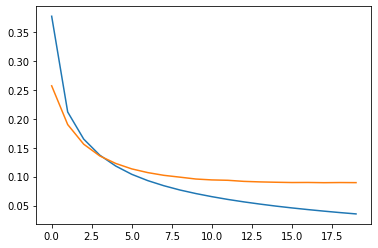

In [14]:
plt.plot(train_losses)
plt.plot(test_losses)

In [15]:
 mlp.evaluate(test_X,test_Y)

0.9741

In [19]:
start_idx = 1000
examples = test_X[start_idx:start_idx+5]
predictions = mlp.predict(examples)

In [20]:
print(predictions)

[9 0 2 5 1]


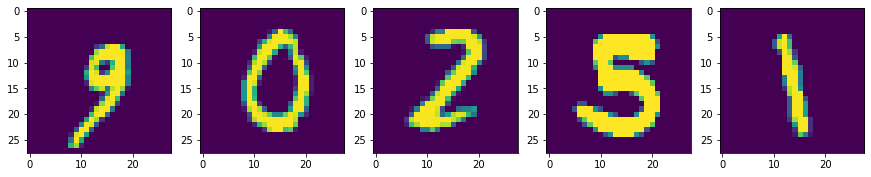

In [21]:
fig, axs = plt.subplots(1, 5,figsize=(15,15))
for idx,a in enumerate(axs):
  a.imshow(test_X[start_idx+idx,:,:])
  